# How to Create a Custom Controller

We can build custom controllers for `pendsim`. In the first part of this guide, we will build our own simple open-loop `Controller` class and test it in simulation.

In the second part of the guide, we will build our own controller based on Model Predictive Control (MPC). We will look at how to store data in a control policy so that we can look at how our controller decides what action to take. We will use some handy built-in methods. And we will explore the MPC technique.

Start by importing the controller base class. We'll also import the other modules necessary to run the simulation.

In [1]:
from pendsim import sim, controller, viz, utils
import numpy as np
import matplotlib.pyplot as plt

We'll create a simple simulation.

In [2]:
dt, t_final = 0.01, 5.0
pend = sim.Pendulum(
    2.0,  # Large mass, 2.0 kg
    1.0,  # Small mass, 1.0 kg
    2.0,  # length of arm, 2.0 meter
    initial_state=np.array([0.0, 0.0, 0.1, 0.0]),
)
simu = sim.Simulation(dt, t_final, lambda t: 0)

A controller executes a `policy` during the simulation loop. It takes the measured `state` and the timestep `dt`, decides what action to take, and returns a tuple containing the `action` and a dictionary containing the `data` that is stored. The `action` is a float that represents the push on the cart's base; if it's positive, we push right, if negative, we push left.

Let's make our own custom controller with a simple open loop policy: after one second, push left for a bit, then stop.

In [3]:
class OpenLoop(controller.Controller):
    def __init__(self):
        self.waitfor = 1.0 # seconds
        self.left_time = 2.5 # seconds
        self.t_elapsed = 0.0 # seconds
    
    def policy(self, state: np.ndarray, dt: float):
        self.t_elapsed += dt
        if self.t_elapsed >= self.waitfor and self.t_elapsed < self.waitfor + self.left_time:
            return 2.0, {}
        else:
            return 0.0, {}

The controller's `policy` is the method that is executed by the simulation. We always return a tuple containing a float and a dict.

Let's run the simulation with our controller:

In [4]:
open_loop_controller = OpenLoop()
results = simu.simulate(pend, open_loop_controller)

100%|███████████████████████████████████████| 500/500 [00:00<00:00, 4816.81it/s]


Then we'll plot the results. We are mostly focused on our control action, so let's plot that alongside $x$ to see how our open-loop controller influenced the base of the cart.

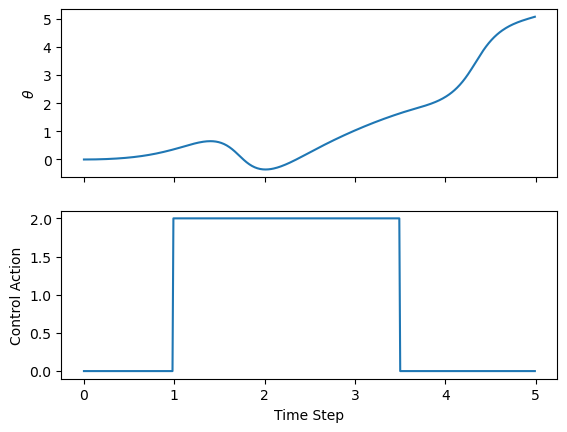

In [5]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(results[("state", "x")], label=r"$\theta$")
ax[0].set_ylabel(r"$\theta$")

ax[1].plot(results[("control action", "control action")], label="Control Action")
ax[1].set_ylabel("Control Action")
ax[1].set_xlabel("Time Step")
plt.show()

Indeed, the pendulum falls over. Let's see how it falls over.

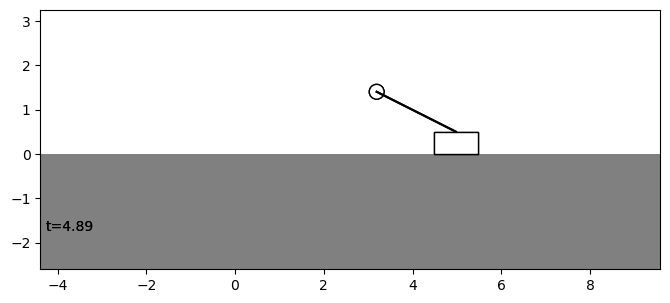

In [6]:
visu = viz.Visualizer(results, pend, dt=dt, speed=1)
ani = visu.animate()
from IPython.display import HTML
HTML(ani.to_html5_video())

Maybe we want to write a custom controller that will keep the base at a steady position, despite what the pendulum does.

## Model-Predictive Control (MPC)

To do this, we'll use the technique of Model Predictive Control (MPC). In the process, we'll explore the `pendsim` API and write a thoroughly customized controller.

One of the things that is very useful to know when dealing with a dynamical system is the [Jacobian Matrix](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant#Dynamical_systems) of the system. The Jacobian matrix tells us how the dynamical system will change. Often, we can break apart a system in two. One part is the "open-loop" behavior of the system -- what happens if we just leave it alone. The other part is the influence of outside forces on the system. For linear systems, we can create  a simple model, called a linear [State Space](https://ccrma.stanford.edu/~jos/StateSpace/StateSpace_4up.pdf) model, that is composed of these two parts. The state space model has two matrices (sometimes more, to account for noise, uncertainty, and other factors). The matrices are $A$ and $B$. Our linear model is:

$$
\{\dot{\bar{x}}\} = [A]\{\bar{x}\} + [B] \{\bar{u}\}
$$

Here, \bar{x} is the state; it is a vector; $A$ is the open-loop *state transition matrix*. $B$ is the *input coefficient matrix*. The sum of these two matrices multiplied by the state and action describes how the state changes ($\dot{\bar{x}}$ is the derivative of the state!) over time.

The properties of the pendulum are what influence the systems's state transition and input coefficient matrices. Our `Pendulum` object helpfully contains these; they're stored in `.jacA` and `.jacB` attributes of the pendulum. So when we create this controller, we need to give it a `pend` object, so that we can get the Jacobians. Then, we'll use them in our `policy` to do a better job of pushing the pendulum around.

We do one more thing with these Jacobians. The equation above is a continuous time equation, but we are operating in discrete time: we only have a finite number of time values at which we evaluate the state. So, we call `get_linear_sys`, which will extract the discretized $A$ and $B$ matrices. We store these into `A` and `B`.

In MPC, we are going to solve an optimization problem over this linear system. Here's how it will go:

+ We will use the $A$ and $B$ matrices to estimate the pendulum's state forward in time.
+ We can set $u$ (control action) to be whatever we want it to be; some $u$ are better than others.
+ We'll define a cost function that is high when we're in a "bad" state and low when we're in a "good" state.
+ We'll solve a convex optimization problem to obtain the *best* possible $u$'s -- those that **minimize** our cost function, according to what *we think will happen*. 
+ Once we have the best set of $u$'s, we take the first one, and actually do it.
+ Then, the system evolves, we get a new state, and we repeat the process.

Convex optimization problems are formulated like so:

Minimize some cost function, according to some constraints.

We have a few constraints: 

+ Our predicted state must obey the state-space model; that is, in the future, we can't have any arbitrary state; from one time point to the next, the system must have evolved according to our SS model.
+ The first state must be our current state. We're extrapolating from now into the future, so we have to start with now!

We can impose whatever constraints we want, too. A popular one is:

+ Our action can't exceed some value. In other words, we can only push the pendulum left or right so hard in a timestep.

Our cost function is pretty simple; we want to keep the pendulum close to some set point. In our controller, let's say that is $x=1$. So we'll say that the cost of a given set of state/action pairs is the sum of squares of all of the positions, $x$, minus the set point ($x=1$) across all the state/action pairs in the set.

For a forward horizon of length $n$, our cost function is:

$$
\sum_{i=0}^{n} (x_i-x_d)^2
$$

Where $x_{d} = 1$.

Let's implement this policy.

In [7]:
import cvxpy as cp

class MPCBaseControl(controller.Controller):
    def __init__(self, pend, dt):
        self.A, self.B = self.get_linear_sys(pend.jacA, pend.jacB, dt)
        self.horizon = 20
        
    def policy(self, state: np.ndarray, dt: float):
        ##### MPC policy #####
        # initialize scalar cost and constraints for the problem
        cost, subjectto = 0.0, []
        # initialize a variable with the forward projection of the state
        s = cp.Variable(shape=(self.horizon, self.A.shape[0]))
        # initialize a variable with the forward projection of the action
        u = cp.Variable(shape=(self.horizon, self.B.shape[1]))
        # add the constraint that the forward projection must start with
        # the current state
        subjectto.append(s[0,:] == state)
        # constrain future predicted states to the linear model A @ x + B @ u
        for i in range(self.horizon-1):
            stateconstraint = s[i+1, :] == self.A @ s[i,:] + self.B @ u[i,:]
            subjectto.append(stateconstraint)
        # constrain control action
        subjectto.append(cp.abs(u) <= 30.0)
        # put a penalty on the base position's distance from x=1.0
        cost = cp.sum_squares(s[:,0] - 1.0)
        # set up the problem 
        problem = cp.Problem(cp.Minimize(cost), subjectto)
        # solve the problem
        problem.solve(solver="ECOS")
        # implement the first projected (optimal) action
        action = np.squeeze(u.value[0])
        ##### end MPC policy ######
        
        # now, we will store some data about the MPC problem
        data = {}
        # the value of the cost function
        data[("cost", "cost")] = cost.value
        # store end-of-horizon predicted state for each state var
        term_state = utils.array_to_kv("terminal state", ["x", "xd", "t", "td"], s.value[-1, :])
        data.update(term_state)

        return action, data

As far as the API goes, we did a few things: 

## Helper methods

The classes have a lot of helper methods that may simplify implementation of some control policy or dynamical systems tasks. Here, we used `get_linear_sys` to get the $A$ and $B$ matrices we needed for our MPC policy. `Pendulum` and `Controller` have a few of these helpers, and they may prove useful for your control task.

## Storing Data from `policy`

At the end of our policy, we stored some data in a dictionary, `data`. The keys of this dict are *columns* of the pandas DataFrame in which our results are stored. It's important to note that the results DataFrame is a Multi-Indexed dataframe. This is because we frequently want to be able to group state variables $[x, \dot{x}, \theta, \dot{\theta}]$ together. when looking at our simulation results.

There is a helper method that we grabbed from `utils` to easily store data. We can give it a a heading, a set of labels (usually, ["x", "xd", "t", "td"]), and a shape (4,) array of data, and it will produce a dict that can be given back to the simulation.

We'll look at this data to get some idea of what happened on the inside of our controller.

Of course, you can do anything inside the `policy`. You can make plots or define custom objects to store data.

In [8]:
mpc_controller = MPCBaseControl(pend, dt)
results = simu.simulate(pend, mpc_controller)

100%|█████████████████████████████████████████| 500/500 [00:13<00:00, 36.39it/s]


Let's look at how our controller performed. It looks like it was able to move the pendulum base ($x$) to $x=1$. And it kept its control action within the constraints we defined ($u \leq 30$)

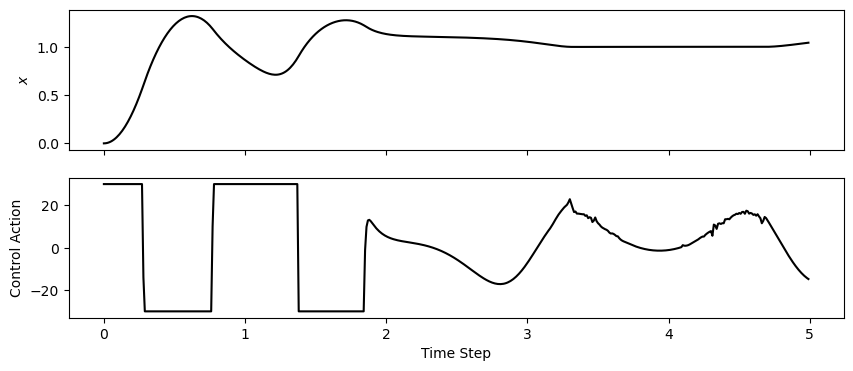

In [9]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10,4))
ax[0].plot(results[("state", "x")], "k", label=r"$x$")
ax[0].set_ylabel(r"$x$")

ax[1].plot(results[("control action", "control action")], "k", label="Control Action")
ax[1].set_ylabel("Control Action")
ax[1].set_xlabel("Time Step")
plt.show()

Let's look at some of the intermediate data that we stored. One important parameter is the cost achieved when we solved our convex problem.

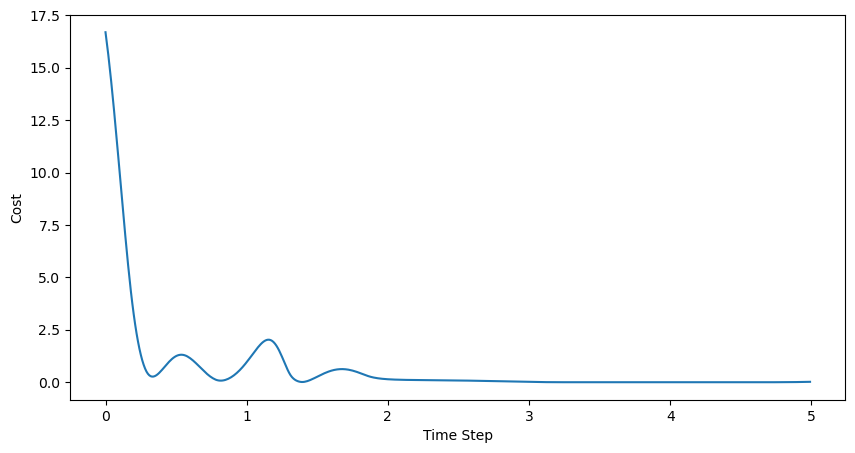

In [10]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(results[("cost", "cost")], label="Cost")
ax.set_ylabel("Cost")
ax.set_xlabel("Time Step")
plt.show()

So it looks like, at the very beginnning, the *best* cost (remember: our convex problem minimizes this cost, so the closer to 0 it is, the better!) was pretty high. Then, as the controller brought the cart near $x=1$, the cost dropped. When the momentum of the pendulum pushed the cart away from $x=1$ at about 1 second in, the cost rose a bit before falling back down as the pendulum was stabilized. Cool!

Another important thing to look at is the "terminal" projected state. Remember that during MPC, we make a bunch of *predictions* about our future state, over some finite horizon. Since we're trying to drive the state towards some desired point, the terminal prediction should be close to the desired state! We can compare the starting state to the predicted final state as we move through time to see whether the MPC algorithm is successfully driving the state in the direction we want.

It's very common to have special costs or constraints attached to the terminal state -- for example, when dealing with a system that is only stable sometimes, we may constrain the terminal state to be within a region of stability for the system to avoid driving the system towards a non-stable position.

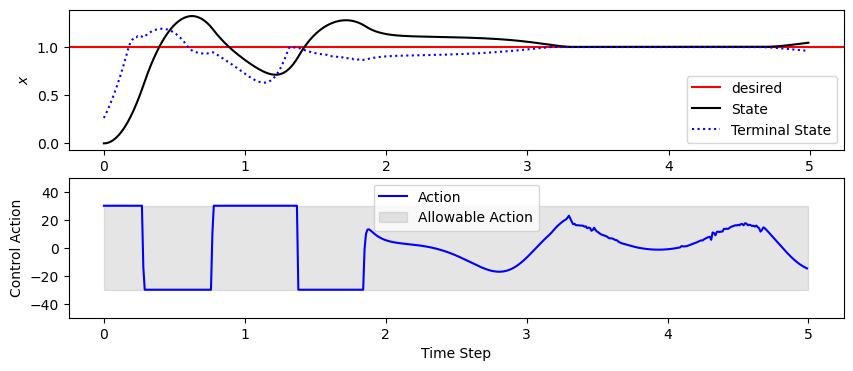

In [11]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(211)
ax1.axhline(y=1.0, c="r", label="desired")
ax1.plot(results["state", "x"], "k", label="State")
ax1.plot(results["terminal state", "x"], "b:", label="Terminal State")
ax1.set_ylabel(r"$x$")
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.plot(results[("control action", "control action")], "b", label="Action")
# show action space with filled polygon
ax2.fill_between([0.0, t_final], y1=-30.0, y2=30.0, color="grey", alpha=0.2, label="Allowable Action")
ax2.set_ylabel("Control Action")
ax2.set_xlabel("Time Step")
ax2.legend()
ax2.set_ylim(-50.0, 50.0)

plt.show()

We can see from the top plot that the policy does indeed attempt to drive the state towards the setpoint: the terminal state is always as close as it can be to the set point. And we can also see that there are some points where, try as it might, the controller cannot drive the terminal state to $x=0$ (top), because it is limited by the constraint on $u$ (bottom).

The ability to store data inside of the policy can be very helpful to understand what's happening in a control strategy.

Finally, we can look at the result of our experiment:

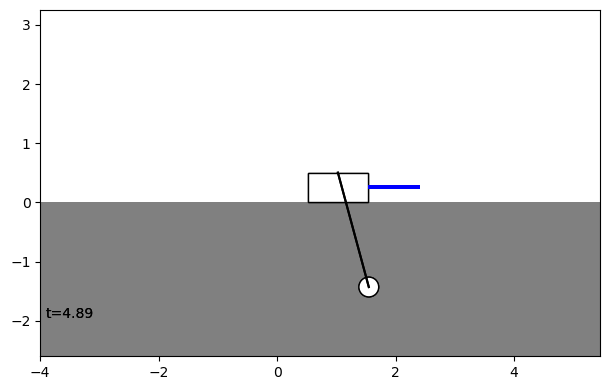

In [12]:
visu = viz.Visualizer(results, pend, dt=dt, speed=1)
ani = visu.animate()
from IPython.display import HTML
HTML(ani.to_html5_video())